In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange

In [2]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

## Import Dataset

In [3]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [4]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [5]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.10, random_state=42)

In [6]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1371, 10)
(1371, 2)
(153, 10)
(153, 2)


In [48]:
BATCH_SIZE = len(Xtrain)

In [49]:
train_dataset = TensorDataset(torch.Tensor(Xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(train_dataset, shuffle=True)

## Define Models

In [50]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(10,100)
        self.hidden1 = nn.Linear(100,50)
        self.output = nn.Linear(50,2)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return x

In [51]:
net = Net()
print(net)

Net(
  (input_layer): Linear(in_features=10, out_features=100, bias=True)
  (hidden1): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
)


In [52]:
def train(net, optimizer, epochs=100, val_split=None):
    loss_list = []
    acc_list = []
    val_loss_list = []
    val_acc_list = []
    history = {"loss" : loss_list, "acc" : acc_list,
               "val_loss": val_loss_list, "val_acc" : val_acc_list}
    
#     optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.)
#     criterion = nn.MSELoss()
    
    if (len(val_split) == 2):
        test_dataset = TensorDataset(torch.Tensor(val_split[0]), torch.Tensor(val_split[1]))
        test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)
#         test_loader = DataLoader(test_dataset, shuffle=True)
    
    for epoch in (t := trange(epochs)):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            out = net(inputs)
            loss = MEE(out, targets)
#             loss = nn.MSELoss(out, targets)
            loss.backward()
            optimizer.step()
            
        acc,_ = evaluate(net, train_loader, verbose=False)
        val_acc, val_loss = evaluate(net, test_loader, verbose=False, criterion=True)
        val_loss_list.append(val_loss)
        loss_list.append(loss)
        acc_list.append(acc)
        val_acc_list.append(val_acc)
        t.set_description('epoch %d/%d loss=%.5f acc=%.2f val_loss=%.5f val_acc=%.2f'
                          %(epoch+1, epochs, loss.item(), acc, val_loss, val_acc))    
            
    return history

In [53]:
def evaluate(net, test_loader, verbose=True, criterion=False):
    correct = 0
    total = 0
    loss = 0

    with torch.no_grad():
        for data in test_loader:
            X,y = data
            output = net(X)
            if (criterion):
                    loss = MEE(output, y)
#                     loss = nn.MSELoss(out, targets)
            for idx, i in enumerate(output):
#                 pred = torch.round(torch.max(i))
                pred = output[idx]
#                 print(pred)
#                 print(y[idx])
#                 print(pred)
#                 print(y[idx])
                if ((pred == y[idx]).all()):
                    correct+=1
                total+=1
    if verbose:
        print("Accuracy: ", round(correct/total, 2))
#     print(correct)
    return round(correct/total, 2), loss

### Initialize the weights

In [54]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        
net.apply(init_weights)

Net(
  (input_layer): Linear(in_features=10, out_features=100, bias=True)
  (hidden1): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
)

In [55]:
def MEE(y_real, y_pred): 
#     return torch.mean(torch.cdist(y_real, y_pred, p=2))
#     return torch.div(torch.sum(F.pairwise_distance(y_real, y_pred, p=2)), len(y_real))
    return torch.mean(torch.linalg.norm(y_real - y_pred, axis=1))
#     return torch.mean(torch.sqrt(torch.square((y_real - y_pred))))
#     return torch.div(torch.linalg.norm(y_pred - y_real), len(y_real))

In [56]:
optimizer = optim.SGD(net.parameters(),lr = 0.006, momentum = 0.8, weight_decay=0.0001)

In [57]:
history = train(net, epochs=1000, optimizer=optimizer, val_split=(Xval, yval))

epoch 1000/1000 loss=2.86976 acc=0.00 val_loss=3.34428 val_acc=0.00: 100%|██████████| 1000/1000 [01:07<00:00, 14.81it/s]


In [58]:
import sys
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [59]:
from torch_utility import *

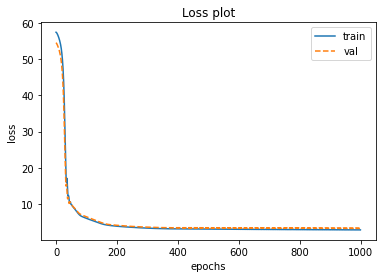

In [60]:
plot_loss(history)

In [61]:
data = [
    history['loss'][-1],
    history['acc'][-1],
    history['val_loss'][-1],
    history['val_acc'][-1],
]
table_info(data)

	    MSE     Accuracy
-----------------------------
Train	|2.8697636|	0.00|
Test	|3.3442764|	0.00|


In [62]:
to_predict = torch.tensor(list(Xval), dtype=torch.float, requires_grad=False)
out = net(to_predict)

In [63]:
out = out.detach().numpy()

In [64]:
x = out[:,0]
y = out[:,1]

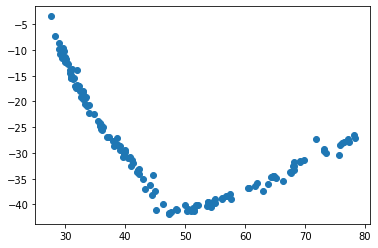

In [65]:
plt.scatter(x,y)

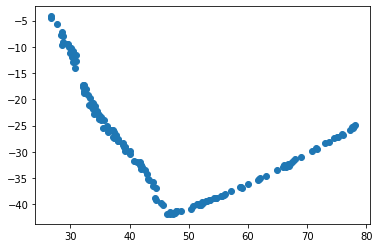

In [66]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [69]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [70]:
mean_euclidean_error(out, yval)

3.3442762

In [41]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [28]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [29]:
class Net(nn.Module):

    def __init__(self, num_units):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(10,num_units)
        self.output = nn.Linear(num_units,2)

    def forward(self, x):
        x = torch.sigmoid(self.input_layer(x))
        x = self.output(x)
        return x

In [30]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
test_net = Net(100,)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.01,
                          batch_size=64,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.8,
                          optimizer__weight_decay=0.0001,
                          optimizer__nesterov = True,
                          criterion=MEE,
                          callbacks=[EarlyStopping(patience=100)]
                         )
# Training
nett.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       51.1258       39.5325  0.2066
      2       32.4036       21.6235  0.0443
      3       17.0926       10.2772  0.0462
      4        9.0690        8.3958  0.0414
      5        8.5086        8.0937  0.0413
      6        8.2209        7.8052  0.0443
      7        7.9375        7.5136  0.0409
      8        7.6347        7.1964  0.0425
      9        7.3007        6.8480  0.0414
     10        6.9365        6.4799  0.0412
     11        6.5543        6.1039  0.0449
     12        6.1784        5.7627  0.0444
     13        5.8394        5.4834  0.0436
     14        5.5683        5.2898  0.0382
     15        5.3716        5.1756  0.0418
     16        5.2378        5.1157  0.0405
     17        5.1476        5.0764  0.0415
     18        5.0827        5.0474  0.0415
     19        5.0296        5.0212  0.0419
     20        4.9828        4.9951  0.0433
     21        4.9397        4.9

    132        3.3044        3.4188  0.0338
    133        3.2987        3.4146  0.0347
    134        3.2945        3.4107  0.0338
    135        3.2904        3.4068  0.0335
    136        3.2864        3.4030  0.0336
    137        3.2822        3.3992  0.0334
    138        3.2781        3.3956  0.0332
    139        3.2741        3.3920  0.0470
    140        3.2701        3.3884  0.0336
    141        3.2661        3.3849  0.0348
    142        3.2622        3.3814  0.0350
    143        3.2583        3.3779  0.0355
    144        3.2545        3.3744  0.0357
    145        3.2507        3.3710  0.0360
    146        3.2469        3.3677  0.0348
    147        3.2433        3.3629  0.0333
    148        3.2403        3.3618  0.0336
    149        3.2365        3.3568  0.0336
    150        3.2326        3.3548  0.0334
    151        3.2288        3.3502  0.0329
    152        3.2257        3.3484  0.0336
    153        3.2215        3.3446  0.0331
    154        3.2181        3.3

    267        2.9030        3.0774  0.0327
    268        2.9007        3.0756  0.0321
    269        2.8984        3.0739  0.0322
    270        2.8961        3.0722  0.0343
    271        2.8938        3.0705  0.0323
    272        2.8915        3.0687  0.0321
    273        2.8891        3.0669  0.0322
    274        2.8868        3.0651  0.0333
    275        2.8845        3.0633  0.0323
    276        2.8821        3.0614  0.0322
    277        2.8798        3.0595  0.0352
    278        2.8775        3.0575  0.0324
    279        2.8752        3.0556  0.0326
    280        2.8729        3.0537  0.0346
    281        2.8707        3.0518  0.0324
    282        2.8684        3.0499  0.0328
    283        2.8662        3.0480  0.0325
    284        2.8640        3.0461  0.0322
    285        2.8618        3.0442  0.0328
    286        2.8597        3.0424  0.0324
    287        2.8576        3.0405  0.0331
    288        2.8556        3.0388  0.0324
    289        2.8536        3.0

    407        2.6737        2.8998  0.0342
    408        2.6751        2.8968  0.0337
    409        2.6719        2.8990  0.0334
    410        2.6729        2.8968  0.0335
    411        2.6698        2.8985  0.0341
    412        2.6703        2.8960  0.0329
    413        2.6680        2.8983  0.0369
    414        2.6689        2.8954  0.0339
    415        2.6662        2.8976  0.0348
    416        2.6668        2.8952  0.0334
    417        2.6642        2.8970  0.0353
    418        2.6647        2.8945  0.0354
    419        2.6620        2.8966  0.0373
    420        2.6626        2.8942  0.0344
    421        2.6602        2.8959  0.0338
    422        2.6609        2.8936  0.0341
    423        2.6585        2.8956  0.0355
    424        2.6591        2.8935  0.0332
    425        2.6564        2.8952  0.0327
    426        2.6572        2.8930  0.0346
    427        2.6548        2.8949  0.0354
    428        2.6555        2.8927  0.0357
    429        2.6530        2.8

    560        2.5672        2.8874  0.0352
    561        2.5660        2.8868  0.0326
    562        2.5664        2.8871  0.0329
    563        2.5655        2.8857  0.0331
    564        2.5650        2.8863  0.0345
    565        2.5653        2.8867  0.0333
    566        2.5635        2.8866  0.0328
    567        2.5640        2.8866  0.0325
    568        2.5630        2.8853  0.0326
    569        2.5626        2.8859  0.0348
    570        2.5615        2.8863  0.0328
    571        2.5621        2.8863  0.0327
    572        2.5604        2.8861  0.0334
    573        2.5608        2.8859  0.0330
    574        2.5595        2.8851  0.0331
    575        2.5592        2.8866  0.0330
    576        2.5601        2.8852  0.0333
    577        2.5576        2.8863  0.0326
    578        2.5591        2.8842  0.0329
    579        2.5563        2.8850  0.0331
    580        2.5572        2.8845  0.0330
    581        2.5559        2.8861  0.0330
    582        2.5569        2.8

    721        2.4860        2.8710  0.0333
    722        2.4862        2.8690  0.0341
    723        2.4852        2.8681  0.0331
    724        2.4846        2.8667  0.0363
    725        2.4840        2.8667  0.0347
    726        2.4830        2.8655  0.0346
    727        2.4814        2.8675  0.0335
    728        2.4828        2.8689  0.0355
    729        2.4830        2.8692  0.0332
    730        2.4820        2.8700  0.0334
    731        2.4823        2.8648  0.0333
    732        2.4801        2.8657  0.0346
    733        2.4801        2.8664  0.0335
    734        2.4794        2.8712  0.0349
    735        2.4811        2.8675  0.0330
    736        2.4786        2.8712  0.0349
    737        2.4793        2.8637  0.0432
    738        2.4773        2.8672  0.0364
    739        2.4785        2.8685  0.0368
    740        2.4767        2.8642  0.0332
    741        2.4765        2.8657  0.0380
    742        2.4750        2.8659  0.0335
    743        2.4740        2.8

    887        2.4112        2.8647  0.0335
    888        2.4119        2.8605  0.0376
    889        2.4109        2.8605  0.0340
    890        2.4113        2.8577  0.0332
    891        2.4095        2.8653  0.0340
    892        2.4111        2.8550  0.0367
    893        2.4076        2.8639  0.0379
    894        2.4088        2.8574  0.0364
    895        2.4076        2.8602  0.0356
    896        2.4076        2.8570  0.0349
    897        2.4061        2.8650  0.0378
    898        2.4078        2.8572  0.0346
    899        2.4063        2.8597  0.0375
    900        2.4071        2.8572  0.0382
    901        2.4041        2.8663  0.0332
    902        2.4068        2.8582  0.0328
    903        2.4048        2.8596  0.0361
    904        2.4042        2.8569  0.0351
    905        2.4035        2.8599  0.0361
    906        2.4053        2.8578  0.0344
    907        2.4030        2.8667  0.0369
    908        2.4057        2.8562  0.0355
    909        2.4022        2.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (input_layer): Linear(in_features=10, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=2, bias=True)
  ),
)

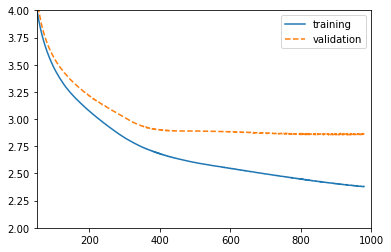

In [48]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,4)
plt.xlim(50,1000)
plt.legend()
plt.show()

In [32]:
prova = nett.predict(Xval)

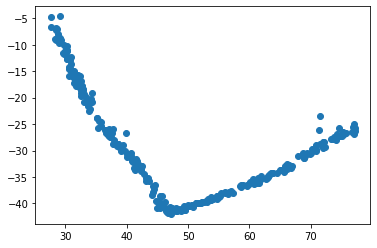

In [33]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

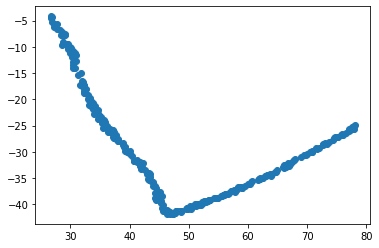

In [34]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [42]:
mean_euclidean_error(prova, yval)

3.096183